# Effect of $m$ on Average Treatment Effect

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch

from misc.agm import calibrateAnalyticGaussianMechanism

%matplotlib inline

# set random seed
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# no. experiments, no. samples, dim, X
ne = 500
ns = [1500, 2000, 2500, 3000, 3500]
dim = 50

# true treatment effect tau
tau = 2

In [3]:
# no. of points used to fit log reg
nf = [500, 1000, 1500, 2000, 2500]

# privacy parameters
epses = [0, 0.2, 0.4, 0.8]
delta = torch.tensor(1e-6)

# regularisation coefficient
reg_co = 0.1

In [4]:
# vectors for generating Y, differentiate between Y_0 and Y_1 with true treatment effect tau
# Y = beta^T X + 0.1 Z
# Y_1 = Y + tau, Y_0 = Y
beta_std = 1
beta_dist = torch.distributions.normal.Normal(
    torch.tensor([0], dtype=torch.float64), 
    torch.tensor([beta_std], dtype=torch.float64)
)
beta = beta_dist.sample((dim, 1)).reshape(dim, 1)

In [5]:
# vectors for generating T
# T = exp(-T_w^T X + b)
T_std = 1
T_dist = torch.distributions.normal.Normal(
    torch.tensor([0.0], dtype=torch.float64), 
    torch.tensor([T_std], dtype=torch.float64)
)
T_w = T_dist.sample((dim, 1)).reshape(dim, 1)
T_b = 0

In [6]:
class Log_Reg(torch.nn.Module):
    '''
    Logistic Regression
    '''
    def __init__(self, D_in, D_out):
        super(Log_Reg, self).__init__()
        self.linear = torch.nn.Linear(D_in, D_out, bias=False)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [7]:
def IPW_PPS_Out(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf):
    '''
    average treatment effect with inverse propensity weighting using private propensity scores
    '''
    # get # experiments, # samples, # dimensions
    ne, ns, dim = X.shape

    ################
    # process data #
    ################

    # get Y0 and Y1
    Y0 = Y * (1 - T)
    Y1 = (Y + tau) * T
    
    # split data
    # get splits
    fit_split = nf
    est_split = ns - nf

    # permute indices
    perm = torch.stack(
        [torch.randperm(ns) for i in range(ne)]
    )

    # create splits
    s0 = perm[:, :fit_split]
    s1 = perm[:, fit_split:]

    # create auxiliary indices
    idx = torch.arange(ne)[:, None]

    # split X into fit, estimate splits
    X_s0 = X[idx, s0]
    X_s1 = X[idx, s1]

    # expand dim of T to allow multiplication with X
    T_ex_dim = T.reshape(ne, ns, 1)

    # split X0 and X1 into fit, estimate splits
    X0_s1 = (X * (1 - T_ex_dim))[idx, s1]
    X1_s1 = (X * T_ex_dim)[idx, s1]

    # split T into fit, estimate splits
    T_s0 = T[idx, s0]
    T_s1 = T[idx, s1]

    # split Y0 and Y1 into fit, estimate splits
    Y0_s0 = Y0[idx, s0]
    Y1_s0 = Y1[idx, s0]

    Y0_s1 = Y0[idx, s1]
    Y1_s1 = Y1[idx, s1]
    
    ##############
    # fit models #
    ##############
    
    models = []
    
    for expm in range(ne):
        X = X_s0[expm]
        T = T_s0[expm][:, None]
        model = Log_Reg(dim, 1).double()
        opt = torch.optim.LBFGS(model.parameters(), max_iter=100)

        # define first-order oracle for lbfgs
        def closure():
            if torch.is_grad_enabled():
                opt.zero_grad()
            outputs = model(X)
            for weights in model.parameters():
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, T) + 0.5 * reg_co * weights.norm(2).pow(2)
            if loss.requires_grad:
                loss.backward()
            return loss

        opt.step(closure)

        models.append(model)

    #############################
    # estimate treatment effect #
    #############################

    # initialise pi_hat dictionaries
    pi_hats = {}
    
    # initialise e dictionary
    e = {}
    
    # intialise sigma dictionary
    sig_d = {}

    # get estimated propensity scores
    pi_hats[0] = torch.stack(
        [models[i](X_s1[i]).squeeze() for i in range(ne)]
    )

    # perturb model and get relevant quantities
    for eps in epses[1:]:
        # define sensitivity for log reg
        s_w = 2.0 / (fit_split * reg_co)

        # define sigma for log reg
        sigma = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_w / (eps / 2))
        sigma_2 = sigma ** 2

#         # analytic gaussian mechanism
#         sigma = calibrateAnalyticGaussianMechanism(eps, delta, s_w)
#         sigma_2 = sigma ** 2

        # define z distribution for log reg
        z_dist = torch.distributions.normal.Normal(
            torch.tensor(0.0, dtype=torch.float64),
            torch.tensor(sigma, dtype=torch.float64),
        )

        # draw z for log reg
        z_vecs = z_dist.sample((ne, dim))

        # create temp models
        models_ = copy.deepcopy(models)

        # initialise list for privatised estimated propensity scores
        pi_hats[eps] = []

        # perturb weights with z_vecs
        for i in range(ne):
            model_temp = models_[i]
            model_temp.linear.weight.data.add_(
                z_vecs[i]
            )
            pi_hats[eps].append(
                model_temp(X_s1[i]).squeeze()
            )

        # reshape stacked privatised estimated propensity scores
        pi_hats[eps] = torch.stack(pi_hats[eps])
                        
        # max of abs of Y1_s1 / propensity score for each experiment
        max_abs_Y1_s1_div_ps = torch.max(
            torch.abs(Y1_s1) / ((ns - nf) * pi_hats[eps]), 1
        )[0]
        
        # max of abs of Y0_s1 / (1 - propensity score) for each experiment
        max_abs_Y0_s1_div_1_m_ps = torch.max(
            torch.abs(Y0_s1) / ((ns - nf) * (1 - pi_hats[eps])), 1
        )[0]
        
        # hstack max_abs_Y_s1_div_ps and max_abs_Y_s1_div_1_m_ps
        max_abs_all = torch.stack(
            (max_abs_Y1_s1_div_ps, max_abs_Y0_s1_div_1_m_ps), 1
        )
        
        # replace inf/nan with 1e20 for stability
        max_abs_all[torch.isfinite(max_abs_all) == 0] = 1e20
            
        # define sensitivity for estimation
        s_e = 2 * torch.max(max_abs_all, 1)[0]
        
        # define sigma for estimation
        sigma_e = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_e / (eps / 2))
        sig_d[eps] = sigma_e.detach().numpy()
        sigma_e_2 = sigma_e ** 2
        
#         # analytic gaussian mechanism
#         sigma_e = calibrateAnalyticGaussianMechanism(eps, delta, s_e)
#         sigma_e_2 = sigma_e ** 2

        # define e distribution for estimation
        e_dist = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.tensor([0.0], dtype=torch.float64),
            torch.diag(sigma_e)
        )

        # draw e for estimation
        e[eps] = e_dist.sample().reshape(ne)
    
    # get treatment effects
    # true
    te = {}
    # empirical means and std of means of ERM + private ERM
    te_hats = {'means': [], 'stds': []}
    # means and std of means of privatised te_hats
    te_hats_p = {'means': [], 'stds': []}

    # estimate true treatment effect
    te_ = torch.mean(
        Y1_s1 / prob_vec[idx, s1] - Y0_s1 / (1 - prob_vec[idx, s1]),
        1,
    )
    te['mean'] = te_.mean().detach().numpy()
    te['std'] = te_.std().detach().numpy()
                
    for key in pi_hats.keys():
        # empirical estimate for noiseless case
        # reduce_mean from (ne, est_split) tensor to (ne , 1) matrix
        te_hats_ = torch.mean(
            Y1_s1 / pi_hats[key] - Y0_s1 / (1 - pi_hats[key]),
            1,
        )
        te_hats['means'].append(
            te_hats_.detach().numpy()
        )
        te_hats['stds'].append(
            te_hats_.std().detach().numpy()
        )
        try:
            te_hats_p_ = te_hats_ + e[key]
            te_hats_p['means'].append(
                te_hats_p_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_p_.std().detach().numpy()
            )
        except KeyError:
            # fill first row for later
            te_hats_p['means'].append(
                te_hats_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_.std().detach().numpy()
            )
        
    te_hats['means'] = np.array(te_hats['means'])
    te_hats['stds'] = np.array(te_hats['stds'])
    te_hats_p['means'] = np.array(te_hats_p['means'])
    te_hats_p['stds'] = np.array(te_hats_p['stds'])

    return te, te_hats, te_hats_p, sig_d

In [8]:
def IPW_PPS_Obj(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf):
    '''
    average treatment effect with inverse propensity weighting using private propensity scores
    '''
    # get # experiments, # samples, # dimensions
    ne, ns, dim = X.shape

    # objective perturbation constants
    L = 1 # see from derivation, also http://proceedings.mlr.press/v32/jain14.pdf
    R2 = 1 # as norm is bounded by 1
    c = 0.25
    
    ################
    # process data #
    ################

    # get Y0 and Y1
    Y0 = Y * (1 - T)
    Y1 = (Y + tau) * T
    
    # split data
    # get splits
    fit_split = nf
    est_split = ns - nf

    # permute indices
    perm = torch.stack(
        [torch.randperm(ns) for i in range(ne)]
    )

    # create splits
    s0 = perm[:, :fit_split]
    s1 = perm[:, fit_split:]

    # create auxiliary indices
    idx = torch.arange(ne)[:, None]

    # split X into fit, estimate splits
    X_s0 = X[idx, s0]
    X_s1 = X[idx, s1]

    # expand dim of T to allow multiplication with X
    T_ex_dim = T.reshape(ne, ns, 1)

    # split X0 and X1 into fit, estimate splits
    X0_s1 = (X * (1 - T_ex_dim))[idx, s1]
    X1_s1 = (X * T_ex_dim)[idx, s1]

    # split T into fit, estimate splits
    T_s0 = T[idx, s0]
    T_s1 = T[idx, s1]

    # split Y0 and Y1 into fit, estimate splits
    Y0_s0 = Y0[idx, s0]
    Y1_s0 = Y1[idx, s0]

    Y0_s1 = Y0[idx, s1]
    Y1_s1 = Y1[idx, s1]
    
    ##############
    # fit models #
    ##############

    z_dist = torch.distributions.normal.Normal(
                torch.tensor(0.0, dtype=torch.double),
                torch.tensor(1.0, dtype=torch.double),
                )
    
    models = {}
    
    for eps in epses:
        models[eps] = []
        for expm in range(ne):
            X = X_s0[expm]
            T = T_s0[expm][:, None]
            model = Log_Reg(dim, 1).double()
            opt = torch.optim.LBFGS(model.parameters(), max_iter=100)
            if eps > 0: 
                b = torch.sqrt((4 * (L * R2) ** 2 * (torch.log(1 / delta) + eps / 2)) / ((eps / 2) ** 2)) * z_dist.sample((dim, 1))
                # b = torch.sqrt((8 * (torch.log(2. / delta) + 4 * eps)) / (eps ** 2)) * z_dist.sample((dim, 1))
            else:
                b = torch.zeros((dim, 1)).double()
            
            # define first-order oracle for lbfgs
            def closure():
                if torch.is_grad_enabled():
                    opt.zero_grad()
                outputs = model(X)
                if eps > 0:
                    for weights in model.parameters():
                        reg_noise = 1 / nf * torch.matmul(weights, b) + 0.5 * reg_co * weights.norm(2).pow(2)
                        # reg_noise = 1 / nf * torch.matmul(weights, b) + 0.5 * (2 * c * X_std / (eps * nf) + reg_co) * weights.norm(2).pow(2)
                else:
                    for weights in model.parameters():
                        reg_noise = 0.5 * reg_co * weights.norm(2).pow(2)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, T) + reg_noise
                if loss.requires_grad:
                    loss.backward()
                return loss
            
            opt.step(closure)

            models[eps].append(model)
      
    #############################
    # estimate treatment effect #
    #############################

    # initialise pi_hat dictionaries
    pi_hats = {}
    
    # initialise e dictionary
    e = {}
    
    # intialise sigma dictionary
    sig_d = {}

    # get estimated propensity scores
    pi_hats[0] = torch.stack(
        [models[0][i](X_s1[i]).squeeze() for i in range(ne)]
    )

    for eps in epses[1:]:
        # get perturbed propensity scores
        pi_hats[eps] = torch.stack(
            [models[eps][i](X_s1[i]).squeeze() for i in range(ne)]
        )
                
        # max of abs of Y1_s1 / propensity score for each experiment
        max_abs_Y1_s1_div_ps = torch.max(
            torch.abs(Y1_s1) / ((ns - nf) * pi_hats[eps]), 1
        )[0]
                
        # max of abs of Y0_s1 / (1 - propensity score) for each experiment
        max_abs_Y0_s1_div_1_m_ps = torch.max(
            torch.abs(Y0_s1) / ((ns - nf) * (1 - pi_hats[eps])), 1
        )[0]
        
        # hstack max_abs_Y_s1_div_ps and max_abs_Y_s1_div_1_m_ps
        max_abs_all = torch.stack(
            (max_abs_Y1_s1_div_ps, max_abs_Y0_s1_div_1_m_ps), 1
        )
                
        # replace inf/nan with 1e20 for stability
        max_abs_all[torch.isfinite(max_abs_all) == 0] = 1e20
            
        # define sensitivity for estimation
        s_e = 2 * torch.max(max_abs_all, 1)[0]
        
        # define sigma for estimation
        sigma_e = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_e / (eps / 2))
        sig_d[eps] = sigma_e.detach().numpy()
        sigma_e_2 = sigma_e ** 2
        
#         # analytic gaussian mechanism
#         sigma_e = calibrateAnalyticGaussianMechanism(eps, delta, s_e)
#         sigma_e_2 = sigma_e ** 2

        # define e distribution for estimation
        e_dist = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.tensor([0.0], dtype=torch.float64),
            torch.diag(sigma_e)
        )

        # draw e for estimation
        e[eps] = e_dist.sample().reshape(ne)
    
    # get treatment effects
    # true
    te = {}
    # empirical means and std of means of ERM + private ERM
    te_hats = {'means': [], 'stds': []}
    # means and std of means of privatised te_hats
    te_hats_p = {'means': [], 'stds': []}

    # estimate true treatment effect
    te_ = torch.mean(
        Y1_s1 / prob_vec[idx, s1] - Y0_s1 / (1 - prob_vec[idx, s1]),
        1,
    )
    te['mean'] = te_.mean().detach().numpy()
    te['std'] = te_.std().detach().numpy()
                
    for key in pi_hats.keys():
        # reduce_mean from (ne, est_split) tensor to (ne, 1) matrix
        te_hats_ = torch.mean(
            Y1_s1 / pi_hats[key] - Y0_s1 / (1 - pi_hats[key]), 
            1,
        )
        te_hats['means'].append(
            te_hats_.detach().numpy()
        )
        te_hats['stds'].append(
            te_hats_.std().detach().numpy()
        )
        try:
            te_hats_p_ = te_hats_ + e[key]
            te_hats_p['means'].append(
                te_hats_p_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_p_.std().detach().numpy()
            )
        except KeyError:
            # fill first row for later
            te_hats_p['means'].append(
                te_hats_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_.std().detach().numpy()
            )
        
    te_hats['means'] = np.array(te_hats['means'])
    te_hats['stds'] = np.array(te_hats['stds'])
    te_hats_p['means'] = np.array(te_hats_p['means'])
    te_hats_p['stds'] = np.array(te_hats_p['stds'])

    return te, te_hats, te_hats_p, sig_d

In [18]:
def plot_mult_te(figname, te_list, te_hats_list_, ns, nf, epses, tau):
    '''
    plot the true treatment effect, ERM, private ERM treatment effect
    '''        

    # process inputs
    te_hat_list, te_hats_z_list, te_hats_mu_list = {'mu':[], 'std':[]}, {'mu':[], 'std':[]}, {'mu':[], 'std':[]}

    for i in range(len(nf)):
        te_hat_list['mu'].append(np.mean([te_hats_list_[i]['means'][0]], 1))
        te_hat_list['std'].append(np.std([te_hats_list_[i]['means'][0]]))
        te_hats_z_list['mu'].append(np.mean(te_hats_list_[i]['means'][1:], 1))
        te_hats_z_list['std'].append(np.std(te_hats_list_[i]['means'][1:], 1))
        
  # plot figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.plot(
        nf,
        [i['mean'] for i in te_list],
        marker='o',
        color='magenta',
        lw=3,
        label="$\\tau$",
    )
    ax.errorbar(
        nf,
        np.array(
            [te_hat_list['mu'][i] for i in range(len(nf))]
        ).squeeze(),
        1.96
        / np.sqrt(ne)
        * np.array(
            [te_hat_list['std'][i] for i in range(len(nf))]
        ).squeeze(),
        marker='o',
        color='red',
        lw=3,
        label="$\\hat{\\tau}$",
        capsize=5
    )
    # initialise colour map
    col_map = plt.cm.get_cmap('Set1')

    for i in range(0, len(epses)-1):
#         import pdb; pdb.set_trace()
        # get color
        col = col_map(i / (len(epses) + 1))
        te_hats_z_mu_ = np.array(
            [
                te_hats_z_list['mu'][j][i]
                for j in range(len(nf))
            ]
        ).squeeze()
        te_hats_z_std_ = np.array(
            [
                te_hats_z_list['std'][j][i]
                for j in range(len(nf))
            ]
        ).squeeze()
        ax.errorbar(
            nf,
            te_hats_z_mu_,
            1.96 / np.sqrt(ne) * te_hats_z_std_,
            marker='o',
            color=col,
            lw=3,
            label="$\\hat{\\tau}_n^{\\epsilon}$ for $\epsilon$="
            + str(epses[i+1]),
            capsize=5,
            alpha=0.5
        )

    ax.set_title(
        "$\\tau$"
        + ", $\\hat{\\tau}$"
        + ", $\\hat{\\tau}_n^{\\epsilon}$"
        + " against $m$ for $\\tau$ = {}".format(tau),
        fontsize=20,
    )
    ax.set_xlabel("sample size ($m$)", fontsize=18)
    ax.set_xticks(nf)
    ax.set_xticklabels(
        [
            "$0.5\\times10^3$",
            "$10^3$",
            "$1.5\\times10^3$",
            "$2\\times10^3$",
            "$2.5\\times10^3$",
#             "$3\\times10^3$"
        ]
    )

    ax.tick_params(labelsize=16)

    if tau > 0.1:
        ax.set_ylim(1.9, 5.25)
        ax.legend(fontsize=16, loc=1)
    else:
        ax.set_ylim(-0.35, 0.55)
        ax.legend(fontsize=16, loc=4)
    
    fig.tight_layout()
    fig.savefig(figname + '.pdf', dpi=100)

## $\tau = 2$

In [10]:
# create lists for results
te_list_out, te_hats_list_out, te_hats_p_list_out = [], [], []

for i in range(len(ns)):
    # draw ne separate ns samples
    X_std = 3
    X_dist = torch.distributions.normal.Normal(
        torch.tensor([0.0], dtype=torch.float64), 
        torch.tensor([X_std], dtype=torch.float64)
    )
    X = [X_dist.sample((ns[i], dim)).squeeze() for j in range(ne)]
    
    # restrict X to ||x||_2 \leq 1 to fit assumption for each experiment
    X = torch.stack([X[j] / X[j].norm(dim=1).max() for j in range(ne)])

    # generate Y
    Y_std = 0.1
    Y = torch.einsum('kl,ijk->ij',beta, X) + Y_std * torch.randn(ne, ns[i], dtype=torch.float64)
    
    # generate T \in {0, 1}
    prob_vec = torch.sigmoid(torch.einsum('kl,ijk->ij', T_w, X) + T_b)
    T = torch.bernoulli(prob_vec)

#     te, te_hats, te_hats_p, _ = IPW_PPS_Obj(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf[i])
    te, te_hats, te_hats_p, _ = IPW_PPS_Out(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf[i])
    
    te_list_out.append(te); te_hats_list_out.append(te_hats); te_hats_p_list_out.append(te_hats_p)

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


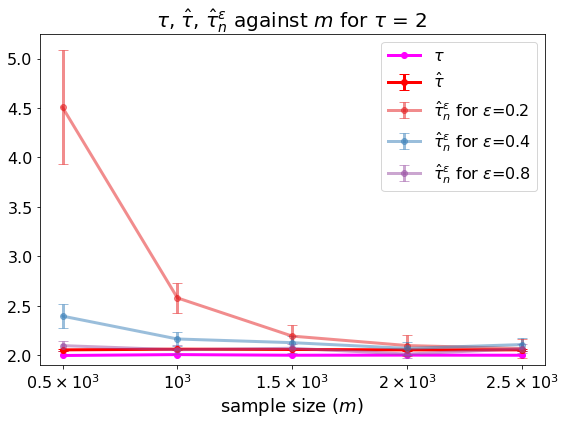

In [19]:
plot_mult_te('sim_tau_'+str(tau)+'_m', te_list_out, te_hats_p_list_out, ns, nf, epses, tau)

In [12]:
# create lists for results
te_list_obj, te_hats_list_obj, te_hats_p_list_obj = [], [], []

for i in range(len(ns)):
    # draw ne separate ns samples
    X_std = 3
    X_dist = torch.distributions.normal.Normal(
        torch.tensor([0.0], dtype=torch.float64), 
        torch.tensor([X_std], dtype=torch.float64)
    )
    X = [X_dist.sample((ns[i], dim)).squeeze() for j in range(ne)]
    
    # restrict X to ||x||_2 \leq 1 to fit assumption for each experiment
    X = torch.stack([X[j] / X[j].norm(dim=1).max() for j in range(ne)])

    # generate Y
    Y_std = 0.1
    Y = torch.einsum('kl,ijk->ij',beta, X) + Y_std * torch.randn(ne, ns[i], dtype=torch.float64)
    
    # generate T \in {0, 1}
    prob_vec = torch.sigmoid(torch.einsum('kl,ijk->ij', T_w, X) + T_b)
    T = torch.bernoulli(prob_vec)

    te, te_hats, te_hats_p, _ = IPW_PPS_Obj(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf[i])
    
    te_list_obj.append(te); te_hats_list_obj.append(te_hats); te_hats_p_list_obj.append(te_hats_p)

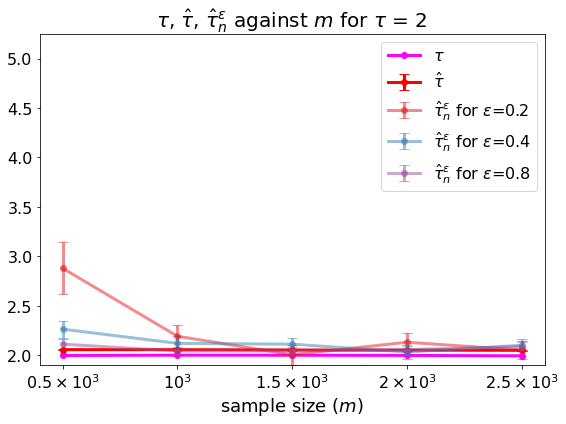

In [20]:
plot_mult_te('sim_tau_'+str(tau)+'_m_obj', te_list_obj, te_hats_p_list_obj, ns, nf, epses, tau)